# RoleCPD

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

try:
    import os
    os.environ["R_HOME"] = r"C:\Program Files\R\R-4.3.1"
    os.add_dll_directory(r"C:\Program Files\R\R-4.3.1\bin\x64")
    import rpy2.robjects as robjects
    from rpy2.robjects import numpy2ri
    from rpy2.robjects.packages import importr

    numpy2ri.activate()
    gSeg = importr("gSeg")
except ImportError:
    print("Error importing rpy2.")

## Data Simulation
We simulate a sequence of role permutations for 10 outfield players (N=10).

Phase 1 (0-150 frames): Standard assignment.

Phase 2 (151-300 frames): Tactical switch (Player 7 and Player 9 swap roles permanently).

Phase 3 (301-450 frames): Another tactical switch (Player 3 and Player 4 swap roles permanently).

Noise: Random temporary swaps to mimic real-game dynamics in 10\% of frames.

In [2]:
def generate_synthetic_role_data(T=450, N=10, switch_times=[150, 300], noise_level=0.1):
    """
    Generates a sequence of role permutations.
    Returns: Array of shape (T, N) where row t is the permutation at time t.
    """
    # Phase 1
    # Base permutation: Identity
    base_roles = np.arange(N)
    
    # Phase 2
    # Tactical Change: Swap roles 7 and 9
    phase2_roles = base_roles.copy()
    phase2_roles[7], phase2_roles[9] = 9, 7

    # Phase 3
    # Tactical Change: Swap roles 3 and 4
    phase3_roles = base_roles.copy()
    phase3_roles[3], phase3_roles[4] = 4, 3

    permutations = []
    
    for t in range(T):
        # Determine dominant tactic
        if t < switch_times[0]:
            current_perm = base_roles.copy()
        elif t < switch_times[1]:
            current_perm = phase2_roles.copy()
        else:
            current_perm = phase3_roles.copy()
            
        # Add temporary noise (random temporary swaps)
        if np.random.rand() < noise_level:
            # Randomly swap two players to simulate temporary cover/overlap
            i, j = np.random.choice(N, 2, replace=False)
            current_perm[i], current_perm[j] = current_perm[j], current_perm[i]
            
        permutations.append(current_perm)
        
    return np.array(permutations)

In [3]:
# Generate Data
T, N = 450, 10
permutations = generate_synthetic_role_data(T=T, N=N, switch_times=[150, 300])
permutations

array([[0, 1, 2, ..., 7, 8, 9],
       [0, 1, 2, ..., 7, 8, 9],
       [0, 1, 2, ..., 7, 8, 9],
       ...,
       [0, 1, 2, ..., 7, 8, 9],
       [0, 1, 2, ..., 7, 5, 9],
       [0, 1, 2, ..., 7, 8, 9]], shape=(450, 10))

## Distance Metric

We use the Hamming distance (switch rate), relative to the dominant permutation, and remove high-noise frames. The switch rate (> 0.7) is the one used in the paper.

In [4]:
def hamming_distance(perm_a, perm_b):
    """
    Calculates normalized Hamming distance (Switch Rate) between two permutations.
    """
    N = len(perm_a)
    diffs = np.sum(perm_a != perm_b)
    return diffs / N

def preprocess_permutations(perms, N=10):
    """
    1. Identifies the global dominant permutation (Identity).
    2. Calculates Switch Rate for every frame.
    3. Filters out frames with Switch Rate > 0.7.
    """
    vals, counts = np.unique(perms, axis=0, return_counts=True)
    dominant_perm = vals[np.argmax(counts)]
    
    valid_indices = []
    switch_rates = []
    
    for t in range(len(perms)):
        sr = hamming_distance(perms[t], dominant_perm)
        switch_rates.append(sr)
        
        if sr <= 0.7:  # Threshold from paper
            valid_indices.append(t)
            
    return np.array(valid_indices), np.array(switch_rates)

Total Frames: 450, Valid Frames: 450


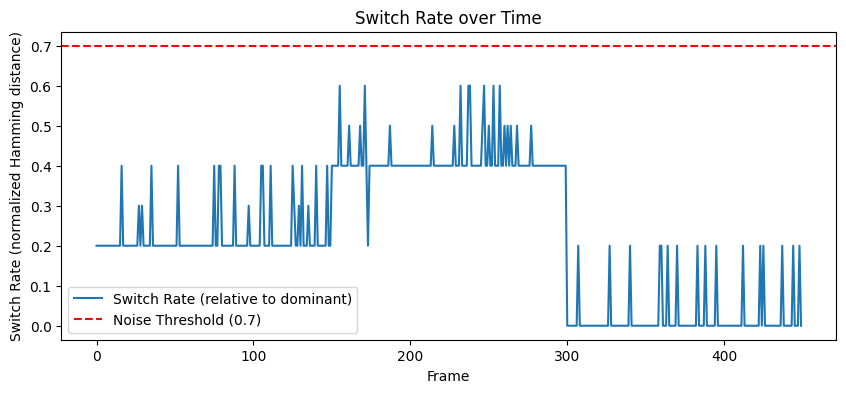

In [5]:
valid_idx, switch_rates = preprocess_permutations(permutations)
valid_perms = permutations[valid_idx]

print(f"Total Frames: {T}, Valid Frames: {len(valid_idx)}")
plt.figure(figsize=(10, 4))
plt.plot(switch_rates, label="Switch Rate (relative to dominant)")
plt.axhline(0.7, color='r', linestyle='--', label="Noise Threshold (0.7)")
plt.title("Switch Rate over Time")
plt.xlabel("Frame")
plt.ylabel("Switch Rate (normalized Hamming distance)")
plt.legend()
plt.savefig("../figures/RoleCPD_SwitchRate.png")
plt.show()

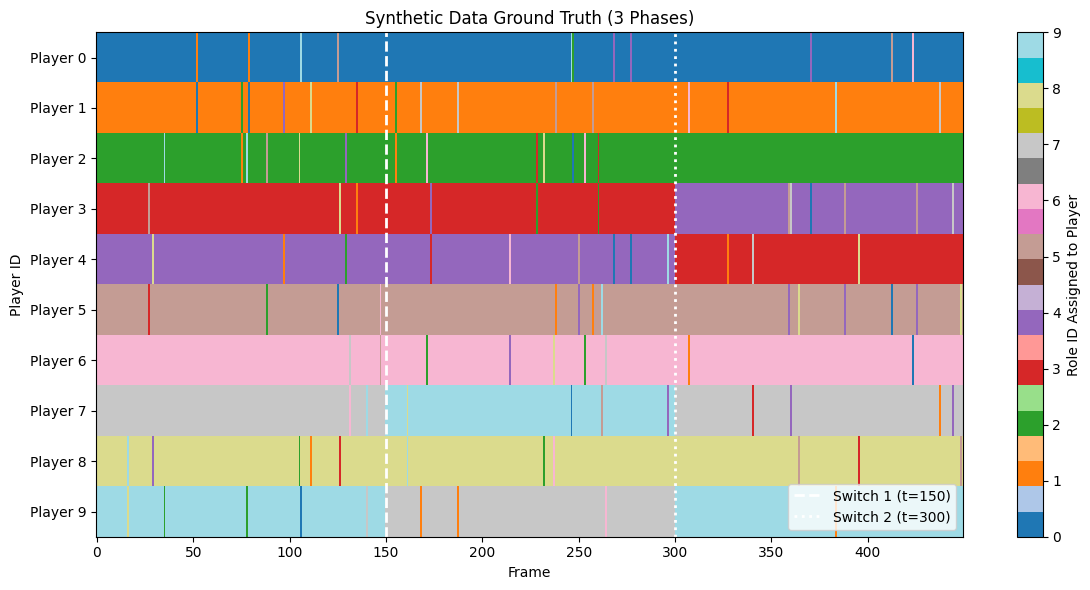

In [6]:
plt.figure(figsize=(12, 6))
plt.imshow(permutations.T, aspect='auto', cmap='tab20', interpolation='nearest')
plt.colorbar(label="Role ID Assigned to Player")
plt.xlabel("Frame")
plt.ylabel("Player ID")
plt.title("Synthetic Data Ground Truth (3 Phases)")
plt.axvline(150, color='white', linestyle='--', linewidth=2, label='Switch 1 (t=150)')
plt.axvline(300, color='white', linestyle=':', linewidth=2, label='Switch 2 (t=300)')
plt.legend(loc='lower right')
plt.yticks(np.arange(N), [f"Player {i}" for i in range(N)])
plt.tight_layout()
plt.savefig("../figures/RoleCPD_GroundTruth.png")
plt.show()

## Discrete G-Segmentation for RoleCPD
Permutations are non-Euclidean. We compute pairwise Hamming distance matrix for unique permutations and create nearest-neighbor graph (using R).

In [7]:
def run_role_gseg(perms):
    """
    Runs discrete g-segmentation on a sequence of permutations using Hamming Distance.
    """
    # unique permutations and mapping
    uni_perms, inverse_indices = np.unique(perms, axis=0, return_inverse=True)
    y = inverse_indices + 1  # R uses 1-based indexing
    
    n = len(perms)
    n_unique = len(uni_perms)
    
    if n_unique < 2:
        print(f"Warning: Not enough unique permutations ({n_unique}) for g-segmentation.")
        return 0, 1.0  # No change point, p-value = 1

    # Compute Hamming distance matrix
    dist_matrix = np.zeros((n_unique, n_unique))
    for i in range(n_unique):
        for j in range(i, n_unique):
            d = hamming_distance(uni_perms[i], uni_perms[j])
            dist_matrix[i, j] = d
            dist_matrix[j, i] = d
            
    # 3. Pass to R
    numpy2ri.activate()
    robjects.globalenv['dist_mat'] = dist_matrix
    robjects.globalenv['y'] = y
    robjects.globalenv['n_len'] = n
    # SoccerCPD framework uses K=1 and strict boundary windows (n0, n1)
    # n0 = 0.1 * n, n1 = 0.9 * n
    
    r_script = """
    library(gSeg)
    E <- gSeg::nnl(as.dist(dist_mat), K=1)
    res <- gSeg::gseg1_discrete(n_len, E, y, statistics="generalized", n0=0.1*n_len, n1=0.9*n_len)
    tau_hat <- res$scanZ$generalized$tauhat_a
    pval <- res$pval.appr$generalized_a
    """
    try:
        robjects.r(r_script)

        tau = robjects.globalenv['tau_hat'][0]
        pval = robjects.globalenv['pval'][0]
    except Exception as e:
        print(f"Error running g-segmentation in R: {e}")
        return 0, 1.0  # Default return on error
    
    return int(tau), float(pval)

In [8]:
# Run detection on valid frames
tau_idx, pval = run_role_gseg(valid_perms)

# Map back to original time frame
detected_change_point = valid_idx[tau_idx]

print(f"Detected Change Point (Original Frame Index): {detected_change_point}")
print(f"P-value: {pval}")
print(f"True Change Point: {150}")

Generalized edge-count statistic (a) : 
  Estimated change-point location: 300 
  Test statistic: 7895.048 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 300 
  Test statistic: 38250.31 
  Approximated p-value: 0 
Detected Change Point (Original Frame Index): 300
P-value: 0.0
True Change Point: 150


## Significance Test & Results
Criteria: p-value < 0.01, dominant permutation differ on each segment.

In [9]:
def get_dominant_perm(perms):
    vals, counts = np.unique(perms, axis=0, return_counts=True)
    return vals[np.argmax(counts)]

Dominant Permutation Distance: 0.2

>> SIGNIFICANT ROLE CHANGE DETECTED <<


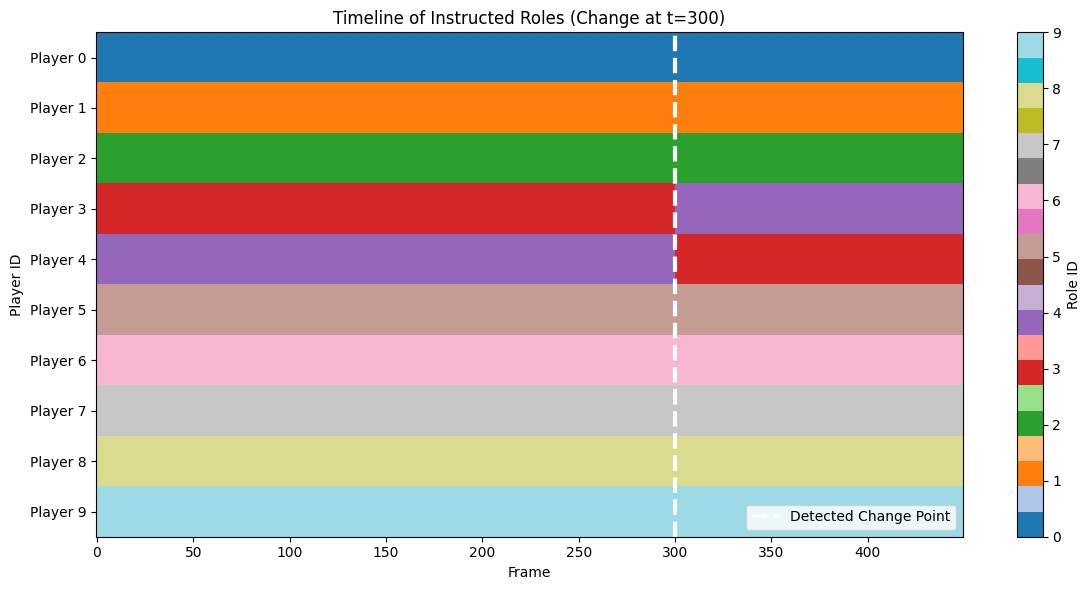

In [10]:
if pval < 0.01:
    seg1_perms = valid_perms[:tau_idx]
    seg2_perms = valid_perms[tau_idx:]
    
    dom1 = get_dominant_perm(seg1_perms)
    dom2 = get_dominant_perm(seg2_perms)
    
    dist_between_segments = hamming_distance(dom1, dom2)
    
    print(f"Dominant Permutation Distance: {dist_between_segments}")
    
    if dist_between_segments > 0:
        print("\n>> SIGNIFICANT ROLE CHANGE DETECTED <<")
        
        # Visualization
        plt.figure(figsize=(12, 6))
        
        timeline = np.zeros((N, T))
        
        for t in range(T):
            if t < detected_change_point:
                timeline[:, t] = dom1
            else:
                timeline[:, t] = dom2
                
        plt.imshow(timeline, aspect='auto', cmap='tab20', interpolation='nearest')
        plt.colorbar(label="Role ID")
        plt.axvline(detected_change_point, color='white', linewidth=3, linestyle='--', label='Detected Change Point')
        plt.xlabel("Frame")
        plt.ylabel("Player ID")
        plt.title(f"Timeline of Instructed Roles (Change at t={detected_change_point})")
        plt.yticks(np.arange(N), [f"Player {i}" for i in range(N)])
        plt.legend(loc='lower right')
        plt.tight_layout()

        plt.savefig("../figures/RoleCPD_OneDetectedPhase.png")
        plt.show()
    else:
        print("Change rejected: Dominant permutations are identical.")
else:
    print("No significant change detected (high p-value).")

As we can see above, gseg1_discrete only detects a single change point, identifying the "strongest" change. To find both, we use Recursive Binary Segmentation:
1. Detect change at $t$.
2. Split data into $[0, t]$ and $[t, T]$.
3. Run detection recursively on both segments.

In [11]:
def recursive_role_segmentation(perms, original_indices, alpha=0.01, min_seg_len=50):
    """
    Recursively detects change points in a sequence of role permutations.

    Parameters:
        perms: The array of permutations (subset of valid frames).
        original_indices: Mapping from current subset indices to original video frame indices.
        alpha: Significance level (p-value threshold).
        min_seg_len: Minimum number of frames required to attempt segmentation.

    Returns:
        List of detected change points (in original frame indices).
    """
    n = len(perms)

    # Base Case: Segment is too short to split
    if n < min_seg_len:
        return []

    # Run G-Segmentation on the current segment
    tau_local, pval = run_role_gseg(perms)

    # Significance Condition 1: P-value, if p-value is too high, we assume no change in this segment
    if pval >= alpha:
        return []

    # Define split point
    split_idx = int(tau_local)
    
    # Boundary check
    if split_idx < 5 or split_idx > n - 5:
        return []

    # Significance Condition 2: Dominant Permutation Change
    # As per the SoccerCPD framework, we reject changes where the dominant role assignment is identical before and after the cut.
    seg1 = perms[:split_idx]
    seg2 = perms[split_idx:]
    
    dom1 = get_dominant_perm(seg1)
    dom2 = get_dominant_perm(seg2)
    
    if hamming_distance(dom1, dom2) == 0:
        # The tactic (most frequent permutation) didn't actually change
        return []

    # If Significant: Record Global Timestamp and Recurse
    global_cp = original_indices[split_idx]
    
    print(f"Significant Change Detected at Frame {global_cp} (p={pval:.2e})")
    print(f"Left Dominant: {dom1}")
    print(f"Right Dominant: {dom2}")

    # Recursive calls
    left_cps = recursive_role_segmentation(seg1, original_indices[:split_idx], alpha, min_seg_len)
    right_cps = recursive_role_segmentation(seg2, original_indices[split_idx:], alpha, min_seg_len)

    return sorted(left_cps + [global_cp] + right_cps)

In [12]:
detected_cps = recursive_role_segmentation(valid_perms, valid_idx, alpha=0.01, min_seg_len=50)

print("\nFinal Detected Change Points:", detected_cps)
print("True Change Points: [150, 300]")

Generalized edge-count statistic (a) : 
  Estimated change-point location: 300 
  Test statistic: 7895.048 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 300 
  Test statistic: 38250.31 
  Approximated p-value: 0 
Significant Change Detected at Frame 300 (p=0.00e+00)
Left Dominant: [0 1 2 3 4 5 6 7 8 9]
Right Dominant: [0 1 2 4 3 5 6 7 8 9]
Generalized edge-count statistic (a) : 
  Estimated change-point location: 150 
  Test statistic: 5891.331 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 150 
  Test statistic: 10355.03 
  Approximated p-value: 0 
Significant Change Detected at Frame 150 (p=0.00e+00)
Left Dominant: [0 1 2 3 4 5 6 7 8 9]
Right Dominant: [0 1 2 3 4 5 6 9 8 7]
Generalized edge-count statistic (a) : 
  Estimated change-point location: 75 
  Test statistic: 8.586694 
  Approximated p-value: 0.2514513 
Generalized edge-count statistic (u) : 
  Estimated change-p

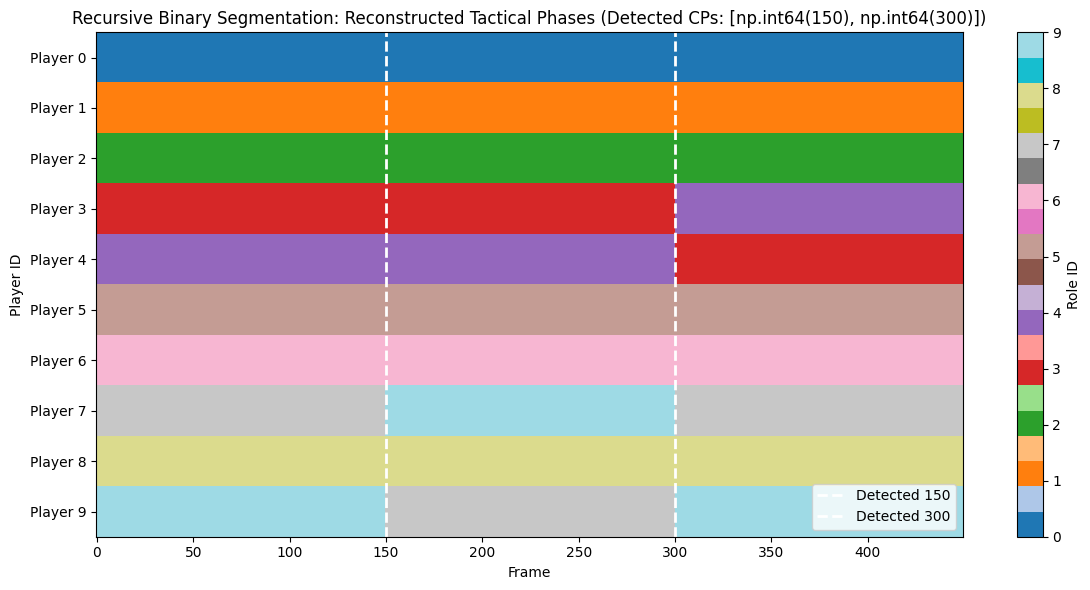

In [13]:
# Visualization of Detected Phases
plt.figure(figsize=(12, 6))

timeline_map = np.zeros((10, T)) # 10 players, T frames
boundaries = [0] + detected_cps + [T]

for i in range(len(boundaries) - 1):
    start, end = boundaries[i], boundaries[i+1]
    
    # Get permutations belonging to this interval
    mask = (valid_idx >= start) & (valid_idx < end)
    if np.any(mask):
        interval_perms = valid_perms[valid_idx[mask]]
        # Calculate dominant permutation for this specific phase
        phase_perm = get_dominant_perm(interval_perms)
    else:
        # If no valid frames in this segment (e.g. pure noise segment)
        phase_perm = np.arange(10) 
        
    # Fill timeline
    for t in range(start, end):
        timeline_map[:, t] = phase_perm

# Plotting
plt.imshow(timeline_map, aspect='auto', cmap='tab20', interpolation='nearest')
plt.colorbar(label="Role ID")
plt.title(f"Recursive Binary Segmentation: Reconstructed Tactical Phases (Detected CPs: {detected_cps})")
plt.xlabel("Frame")
plt.ylabel("Player ID")
plt.yticks(np.arange(10), [f"Player {k}" for k in range(10)])

# Draw lines for detected points
for cp in detected_cps:
    plt.axvline(cp, color='white', linestyle='--', linewidth=2, label=f'Detected {cp}')

plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("../figures/RoleCPD_DetectedPhases.png")
plt.show()